1 Trace(s) in Stream:
XX.LC05.01.001 | 2018-03-03T22:14:05.000000Z - 2018-03-03T22:14:40.995000Z | 200.0 Hz, 7200 samples


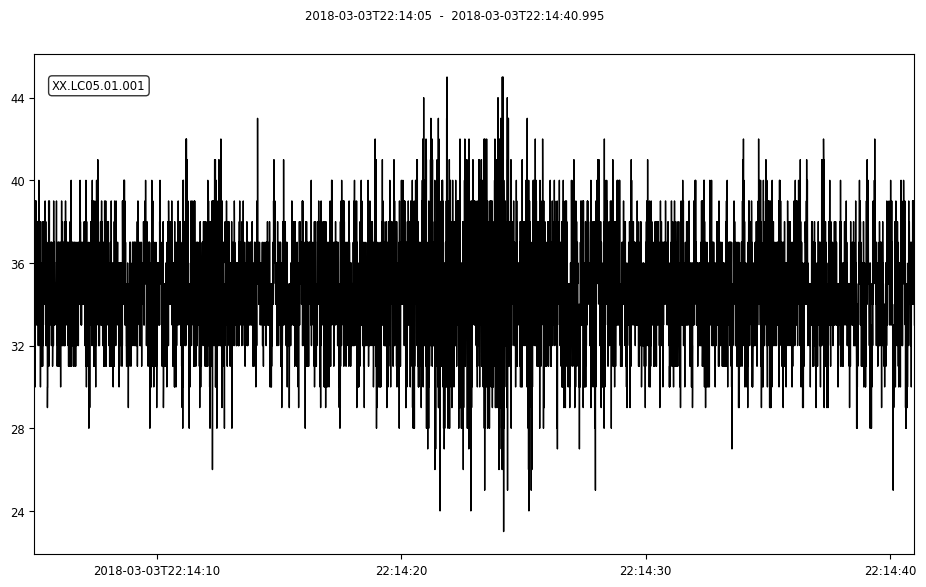

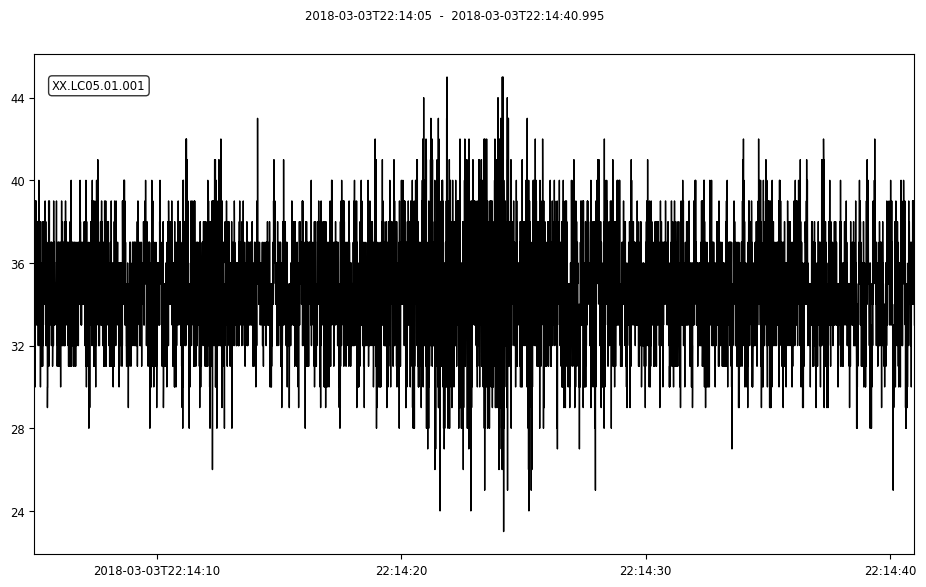

In [4]:
from obspy import read

arch = "../data/LP/2018-03-03-2214-05S.LC05__001_00_01"

st = read(arch)

print(st)
st.plot(size=(1000, 600))

In [5]:
print(st[0].stats)

         network: XX
         station: LC05
        location: 01
         channel: 001
       starttime: 2018-03-03T22:14:05.000000Z
         endtime: 2018-03-03T22:14:40.995000Z
   sampling_rate: 200.0
           delta: 0.005
            npts: 7200
           calib: 1.0
         _format: SEISAN


In [6]:
import os
import numpy as np
import pandas as pd
from scipy.stats import kurtosis, skew
from scipy.signal import welch, find_peaks
from scipy.special import entr

base_path = "../data/"

"""
HY = Hybrid
LP = Long Period
TC = Tectonic
TR = Tremor
VT = Volcano Tectonic
"""
classes = ["HY", "LP", "TC", "TR", "VT"]

features = []

"""
Function to calculate spectral entropy
Spectral entropy is a measure that indicates how disperse or concentrated is the energy of a signal across its frequency spectrum.
If all the energy is concentrated in a few frequencies, the spectral entropy will be low.
If the energy is evenly distributed across all frequencies, the spectral entropy will be high.

This is a good measure because we want to capturate within a simple number the differents spectral patterns of the different classes, meaning
that we can clasify easily the signals reducing the dimensionality of the data.
"""
def spectral_entropy(data, fs):
    f, Pxx = welch(data, fs=fs)
    Pxx_norm = Pxx / np.sum(Pxx)
    entropy = np.sum(entr(Pxx_norm)) / np.log(len(Pxx_norm))  # Normalization [0,1]
    return entropy

for label in classes:
    folder = os.path.join(base_path, label)
    if not os.path.isdir(folder):
        continue

    for fname in os.listdir(folder):
        if not fname.endswith("001_00_01"):
            continue  # aseguramos que sea un archivo de datos
        try:
            st = read(os.path.join(folder, fname))
            tr = st[0]
            data = tr.data.astype(np.float64)
            fs = tr.stats.sampling_rate
            duration = tr.stats.npts / fs

            # Features estadísticos
            mean_val = np.mean(data)
            std_val = np.std(data)
            min_val = np.min(data)
            max_val = np.max(data)
            rms = np.sqrt(np.mean(data**2))
            kurt = kurtosis(data)
            skewness = skew(data)
            energy = np.sum(np.abs(data)**2)
            zcr = np.sum(np.diff(np.sign(data)) != 0) / duration

            # Features espectrales
            entropy = spectral_entropy(data, fs)
            f, Pxx = welch(data, fs=fs)
            dominant_freq = f[np.argmax(Pxx)]

            # Guardar todo
            features.append({
                "filename": fname,
                "filepath": os.path.join(folder, fname),
                "duration": duration,
                "mean": mean_val,
                "std": std_val,
                "min": min_val,
                "max": max_val,
                "rms": rms,
                "kurtosis": kurt,
                "skew": skewness,
                "energy": energy,
                "entropy": entropy,
                "zcr": zcr,
                "dominant_freq": dominant_freq,
                "label": label
            })

        except Exception as e:
            print(f"Error en archivo {fname}: {e}")

# Crear DataFrame final
df = pd.DataFrame(features)

# Mostrar resumen
print(df.head())
print(df['label'].value_counts())

                              filename  \
0  2018-03-04-0532-30S.LC05__001_00_01   
1  2018-03-04-2118-44S.LC05__001_00_01   
2  2018-03-06-0544-55S.LC05__001_00_01   
3  2018-03-08-2155-43S.LC09__001_00_01   
4  2018-03-09-0614-52S.LC10__001_00_01   

                                         filepath  duration        mean  \
0  ../data/HY\2018-03-04-0532-30S.LC05__001_00_01      10.0 -115.652000   
1  ../data/HY\2018-03-04-2118-44S.LC05__001_00_01      76.0   52.852961   
2  ../data/HY\2018-03-06-0544-55S.LC05__001_00_01      45.0 -114.636333   
3  ../data/HY\2018-03-08-2155-43S.LC09__001_00_01      72.0    4.304514   
4  ../data/HY\2018-03-09-0614-52S.LC10__001_00_01      58.0 -237.052672   

          std     min     max         rms   kurtosis      skew        energy  \
0    1.684012  -122.0  -109.0  115.664260   0.283862  0.020140  2.675644e+07   
1    1.814133    46.0    61.0   52.884086   0.094807  0.005510  4.251024e+07   
2    1.515429  -120.0  -108.0  114.646349  -0.052860 -0.

In [15]:
print(df.shape)

(6145, 15)


In [16]:
print(df.isnull().sum())

filename         0
filepath         0
duration         0
mean             0
std              0
min              0
max              0
rms              0
kurtosis         0
skew             0
energy           0
entropy          0
zcr              0
dominant_freq    0
label            0
dtype: int64


In [18]:
# Agrupar por clase y calcular estadísticas
stats_by_class = df.groupby("label")[['mean', 'std', 'rms', 'kurtosis', 'skew', 'energy', 'entropy', 'zcr', 'dominant_freq']].agg(['mean', 'std'])

# Mostrar resumen
print(stats_by_class)

             mean                     std                     rms              \
             mean         std        mean         std        mean         std   
label                                                                           
HY    -116.360718  108.460095   26.966475  106.071273  144.503885  127.941948   
LP    -166.537766  101.403546  109.767194  747.480345  250.810367  738.814745   
TC    -155.862081   98.954617   61.529498  485.017477  202.985843  481.563714   
TR    -139.666427  113.243425   41.740145  243.338831  180.438866  246.382962   
VT    -167.309299   90.166820   36.239646   92.408047  189.703831   99.924892   

       kurtosis                 skew                  energy                \
           mean        std      mean       std          mean           std   
label                                                                        
HY     4.834093   6.074808  0.005751  0.132351  3.992851e+08  1.404706e+09   
LP     2.011387   8.485455 -0.006327  0

C:\Users\edgar\AppData\Local\Temp\ipykernel_77540\3347188984.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df, x="label", y="mean", palette="Set2")


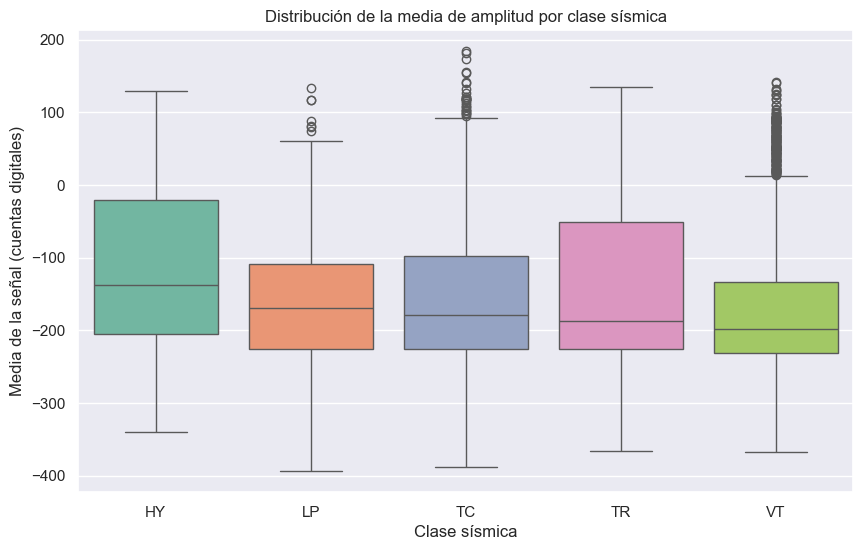

In [19]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.set(style="darkgrid")

# Boxplot de la media por clase
plt.figure(figsize=(10, 6))
sns.boxplot(data=df, x="label", y="mean", palette="Set2")
plt.title("Distribución de la media de amplitud por clase sísmica")
plt.xlabel("Clase sísmica")
plt.ylabel("Media de la señal (cuentas digitales)")
plt.show()

C:\Users\edgar\AppData\Local\Temp\ipykernel_77540\2288650883.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(data=df, x="label", y="mean", palette="Set2", inner="box")


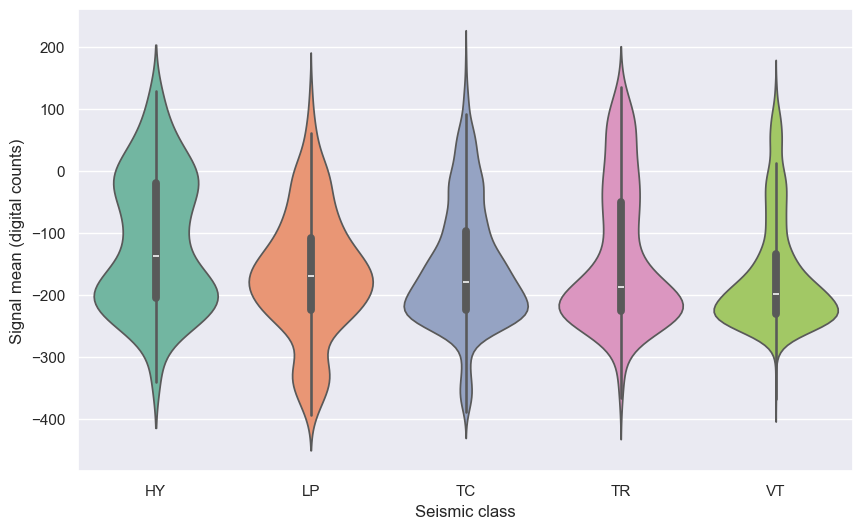

In [24]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.set(style="darkgrid")

# Violinplot of mean amplitude per seismic class (no title, labels in English)
plt.figure(figsize=(10, 6))
sns.violinplot(data=df, x="label", y="mean", palette="Set2", inner="box")
plt.xlabel("Seismic class")
plt.ylabel("Signal mean (digital counts)")
plt.show()


                                   filename  \
count                                  6145   
unique                                 6144   
top     2018-07-28-1903-20S.LC10__001_00_01   
freq                                      2   
mean                                    NaN   
std                                     NaN   
min                                     NaN   
25%                                     NaN   
50%                                     NaN   
75%                                     NaN   
max                                     NaN   

                                              filepath     duration  \
count                                             6145  6145.000000   
unique                                            6145          NaN   
top     ../data/HY\2018-03-04-0532-30S.LC05__001_00_01          NaN   
freq                                                 1          NaN   
mean                                               NaN    49.912612   
std      

C:\Users\edgar\AppData\Local\Temp\ipykernel_77540\1715107786.py:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df, x='label', order=df['label'].value_counts().index, palette="Set2")


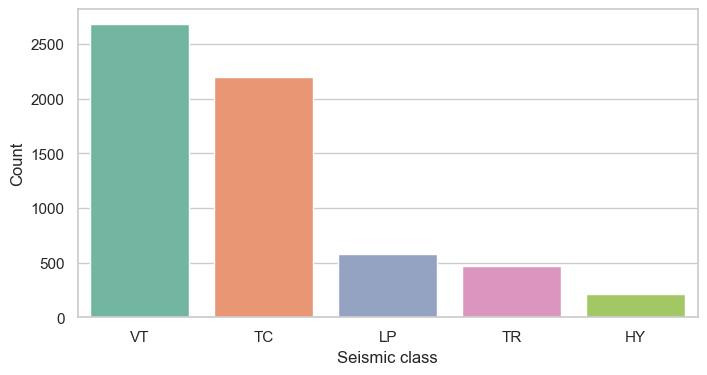

C:\Users\edgar\AppData\Local\Temp\ipykernel_77540\1715107786.py:27: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(data=df, x='label', y=feature, palette="Set3", inner="box")


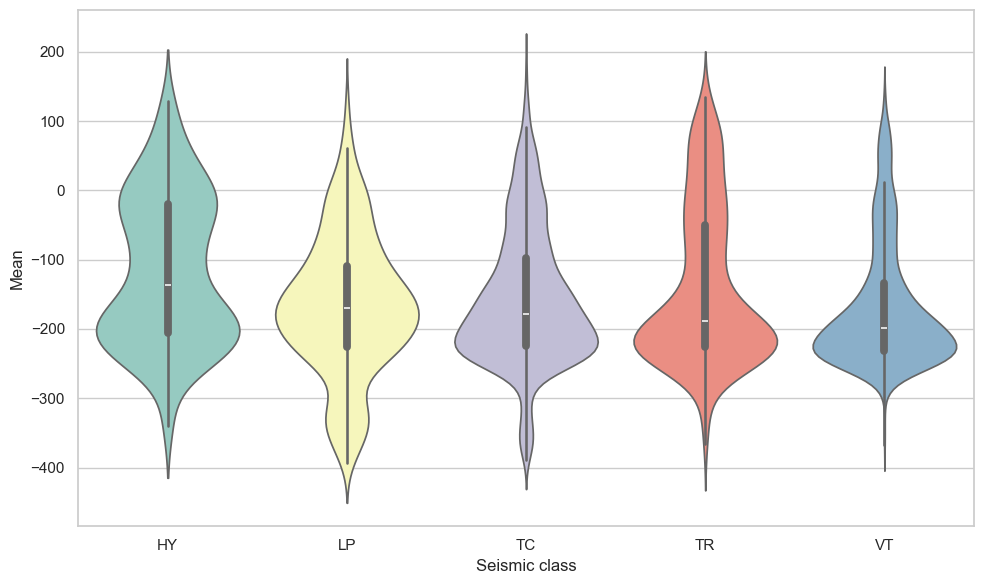

C:\Users\edgar\AppData\Local\Temp\ipykernel_77540\1715107786.py:27: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(data=df, x='label', y=feature, palette="Set3", inner="box")


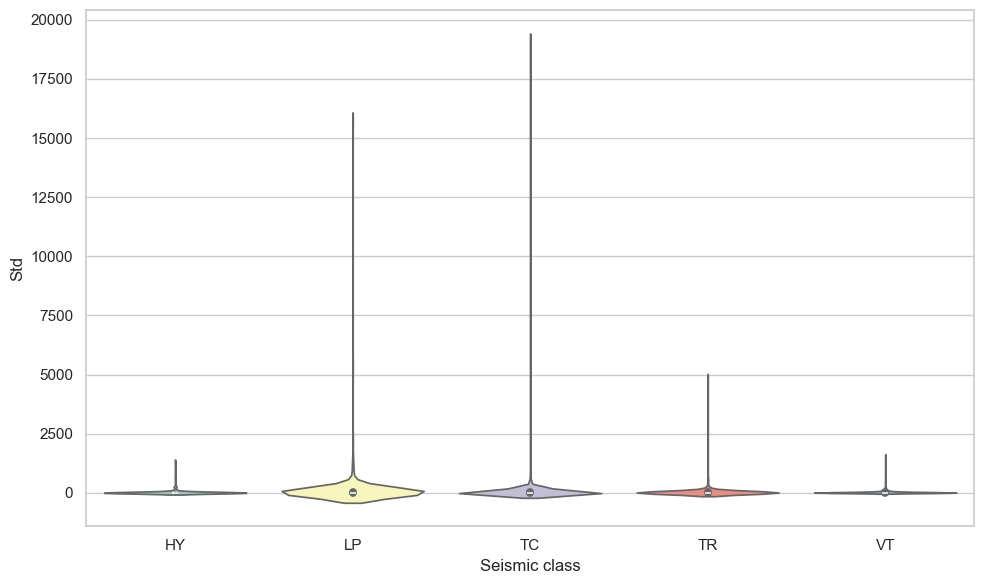

C:\Users\edgar\AppData\Local\Temp\ipykernel_77540\1715107786.py:27: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(data=df, x='label', y=feature, palette="Set3", inner="box")


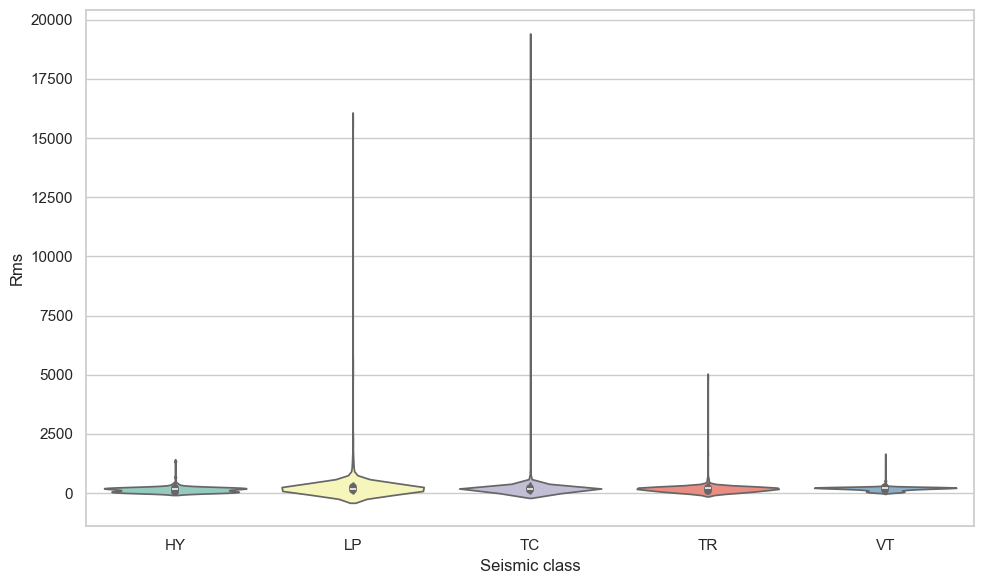

C:\Users\edgar\AppData\Local\Temp\ipykernel_77540\1715107786.py:27: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(data=df, x='label', y=feature, palette="Set3", inner="box")


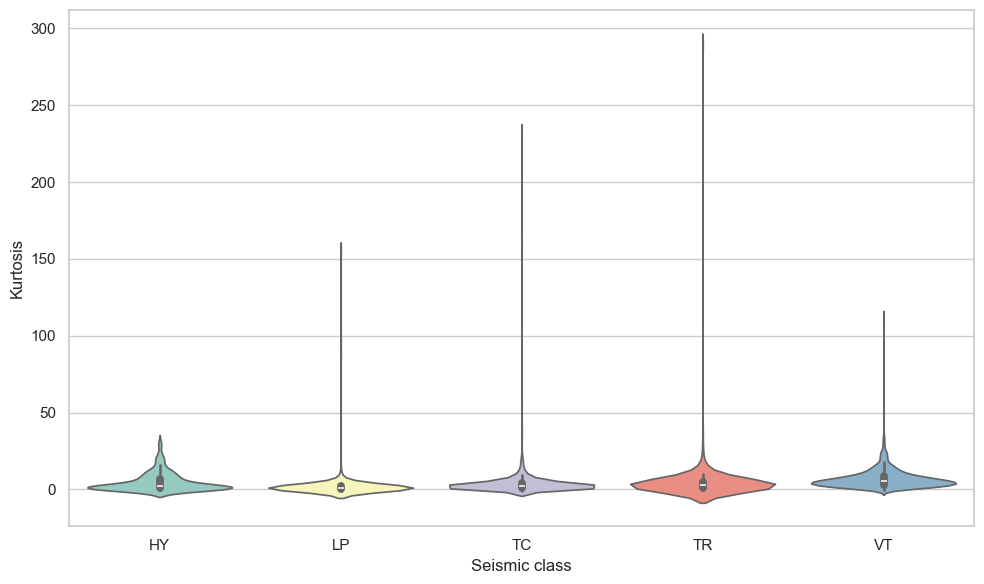

C:\Users\edgar\AppData\Local\Temp\ipykernel_77540\1715107786.py:27: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(data=df, x='label', y=feature, palette="Set3", inner="box")


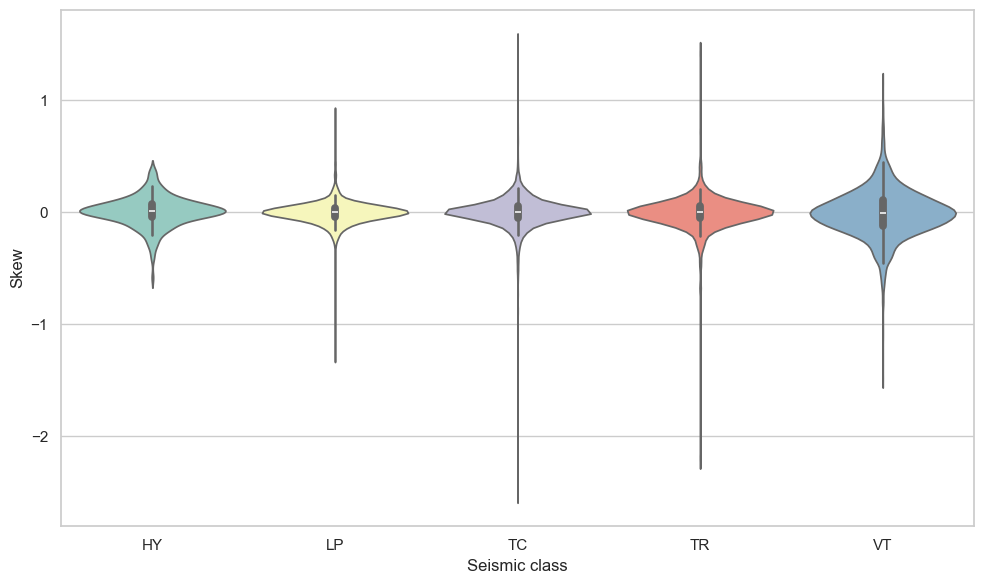

C:\Users\edgar\AppData\Local\Temp\ipykernel_77540\1715107786.py:27: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(data=df, x='label', y=feature, palette="Set3", inner="box")


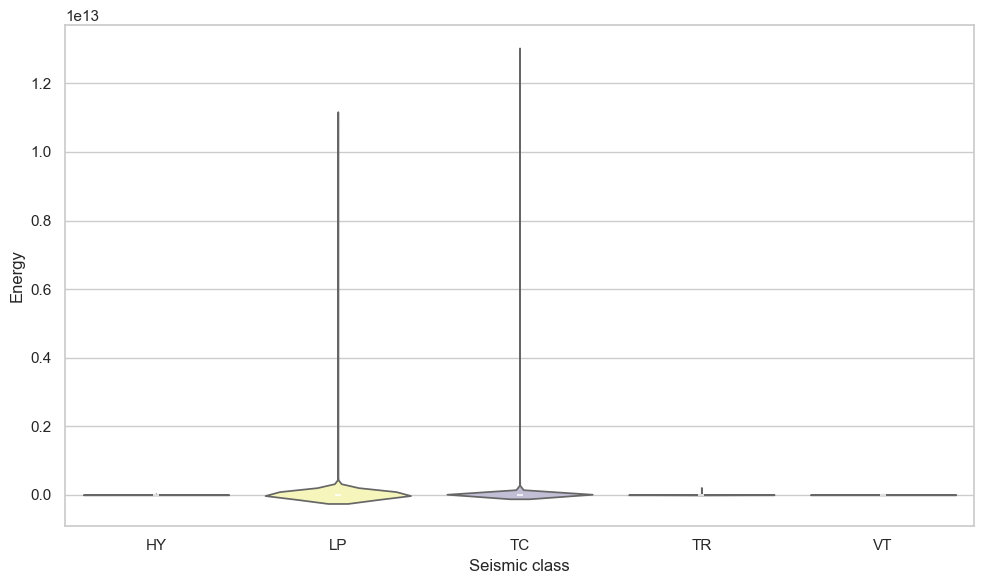

C:\Users\edgar\AppData\Local\Temp\ipykernel_77540\1715107786.py:27: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(data=df, x='label', y=feature, palette="Set3", inner="box")


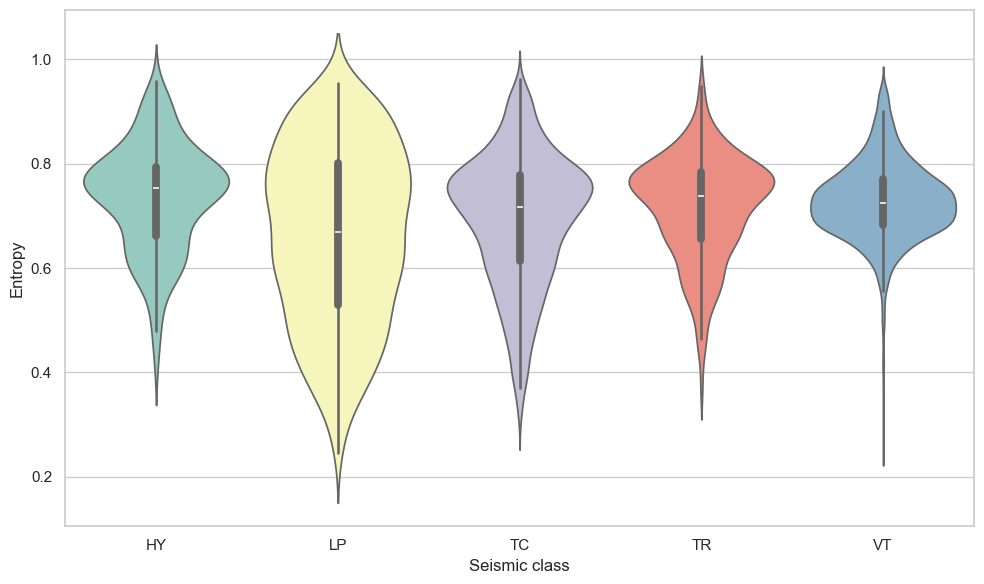

C:\Users\edgar\AppData\Local\Temp\ipykernel_77540\1715107786.py:27: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(data=df, x='label', y=feature, palette="Set3", inner="box")


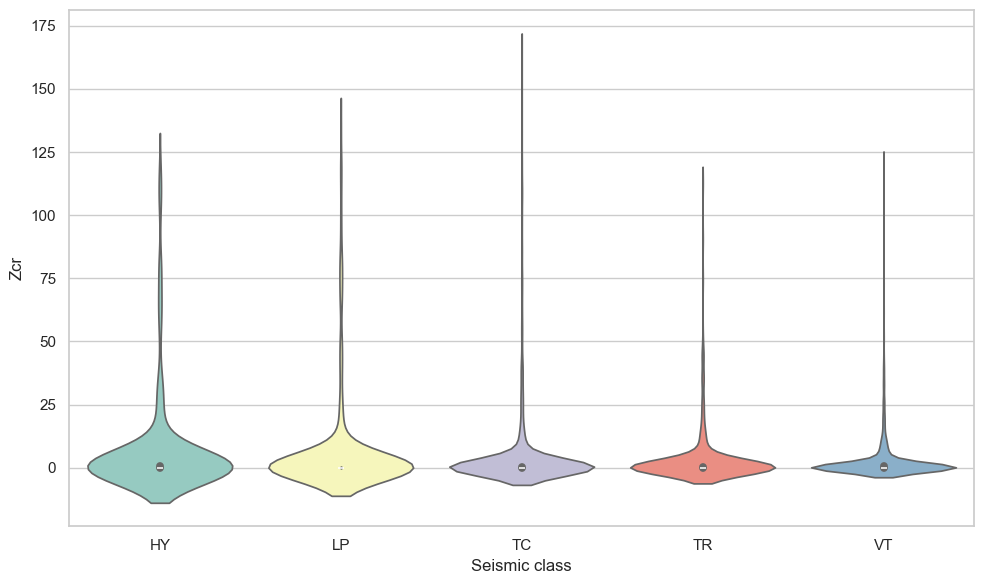

C:\Users\edgar\AppData\Local\Temp\ipykernel_77540\1715107786.py:27: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(data=df, x='label', y=feature, palette="Set3", inner="box")


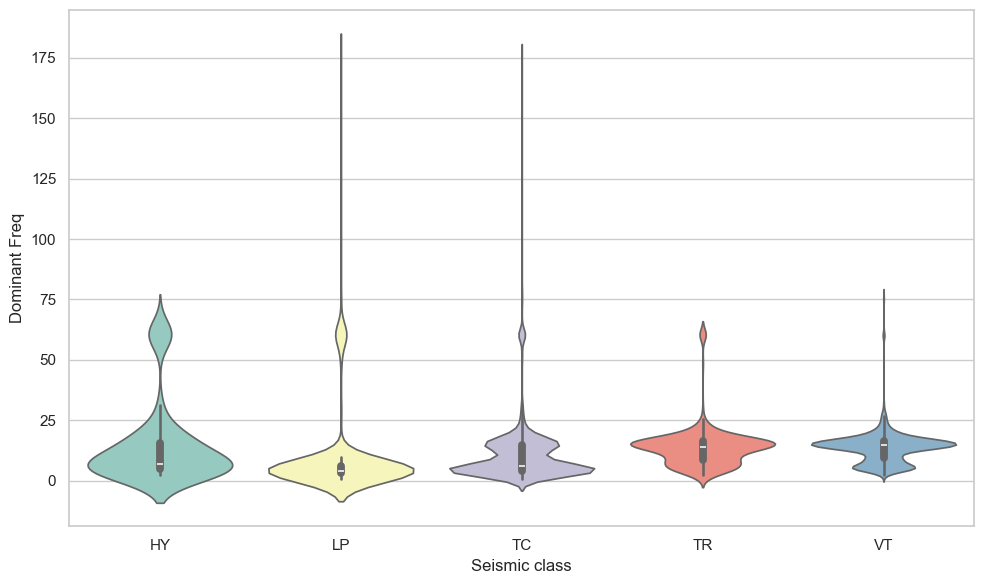

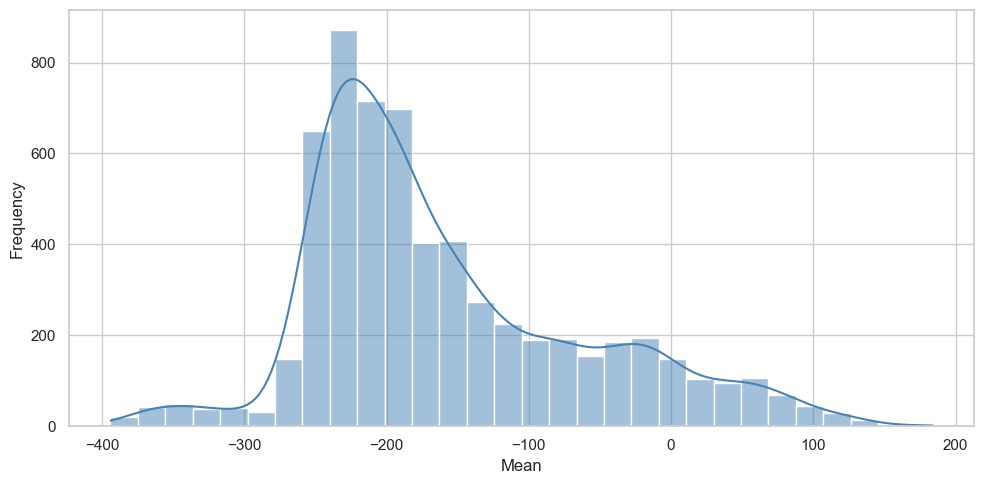

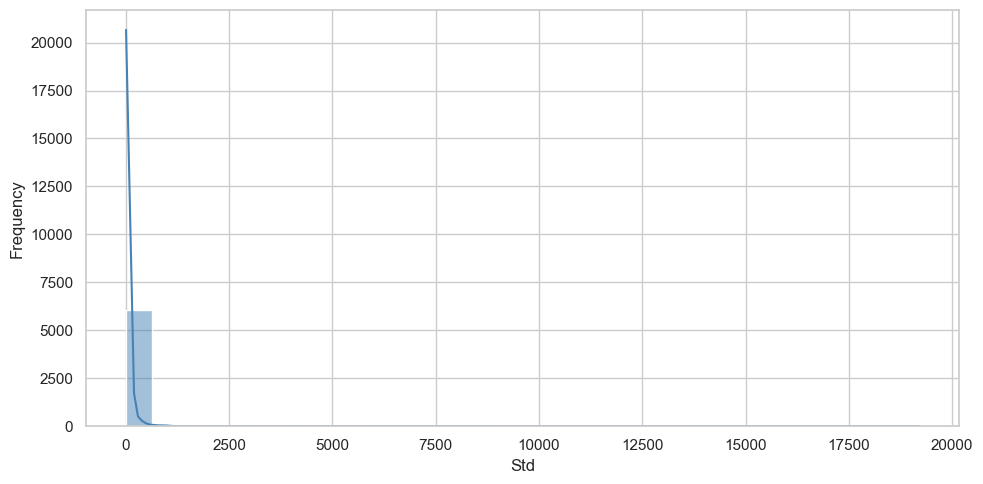

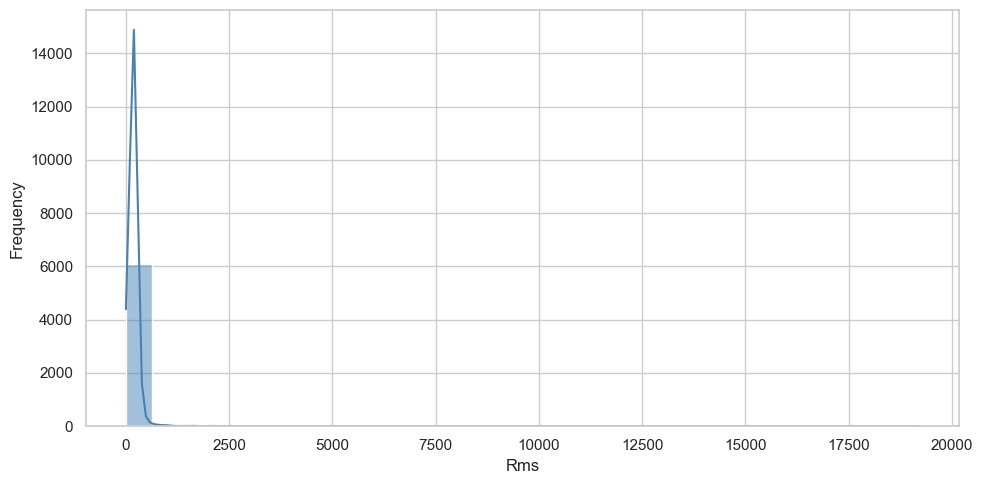

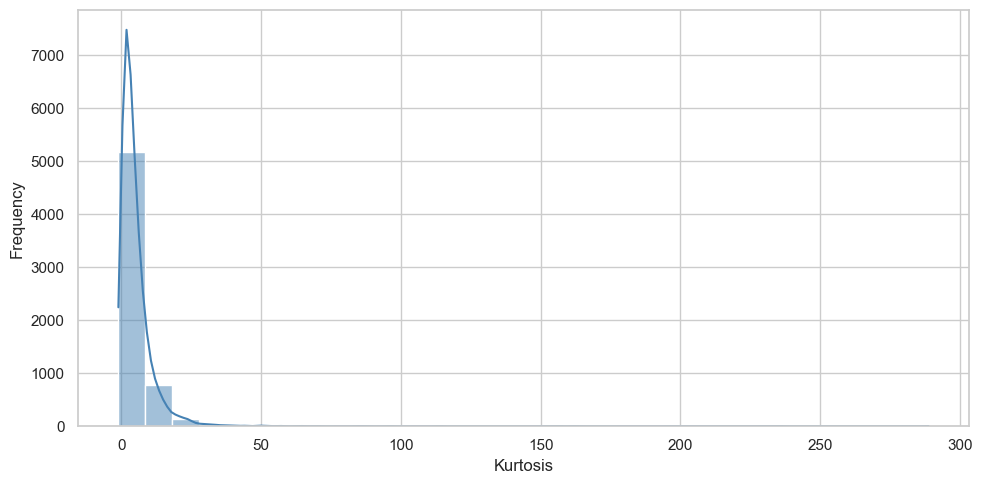

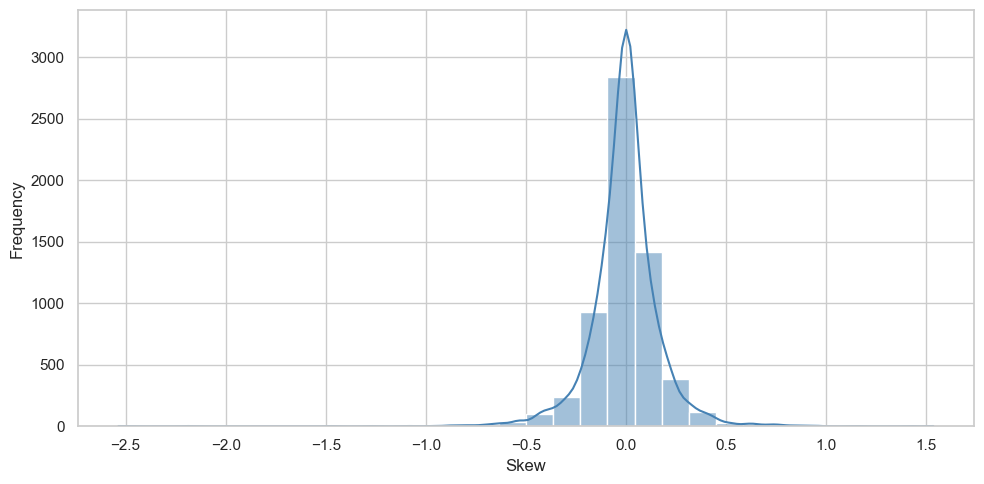

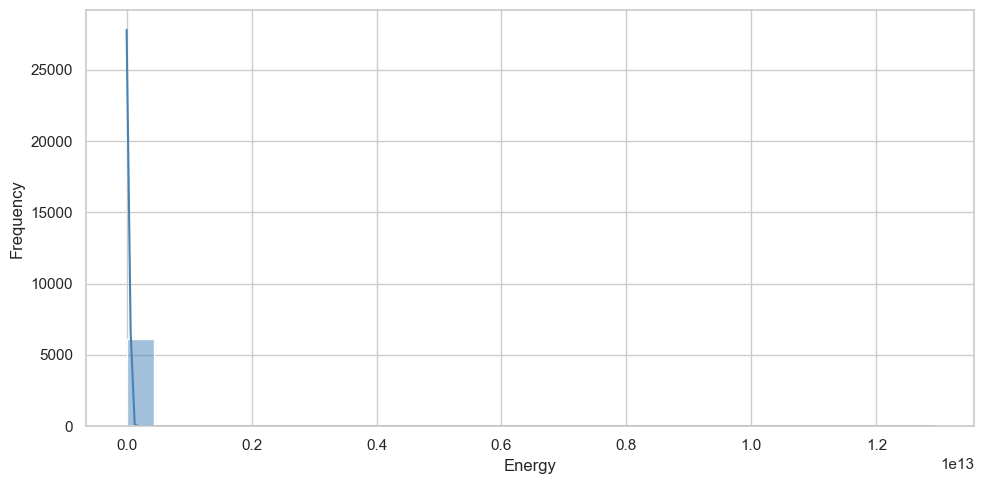

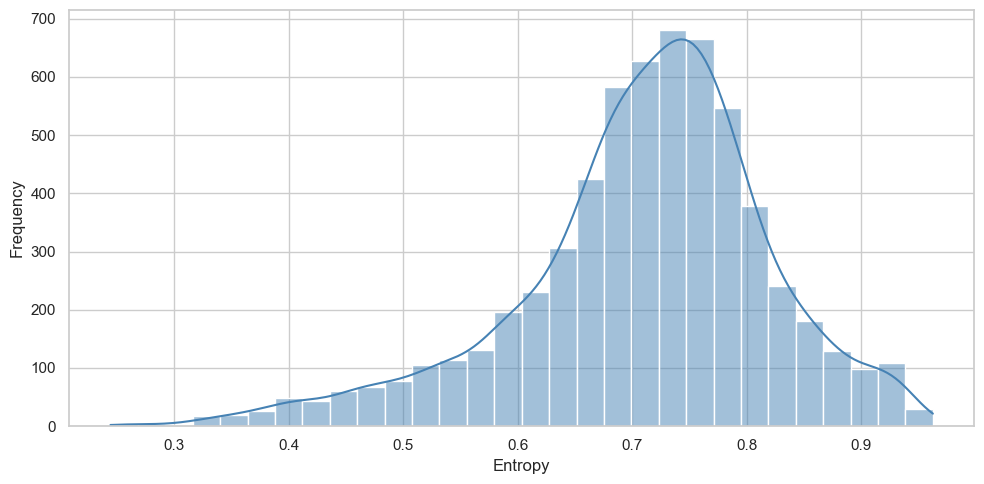

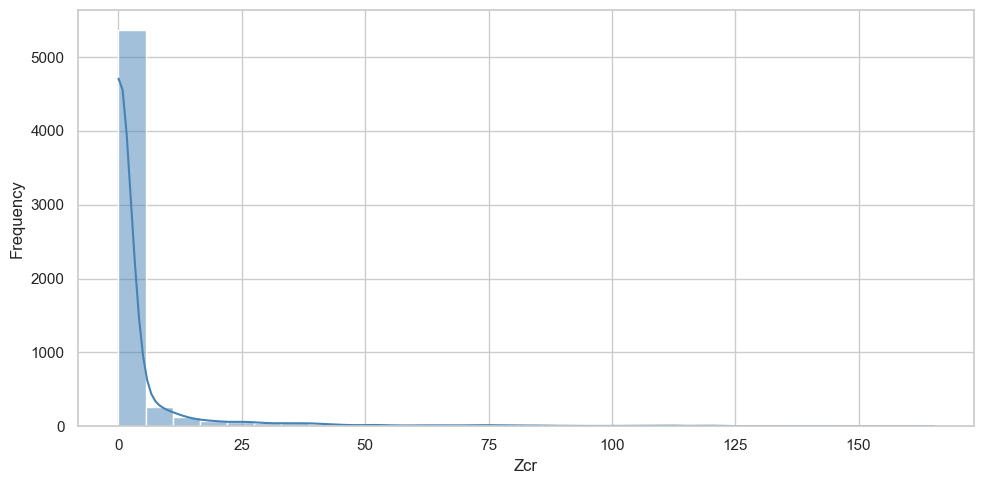

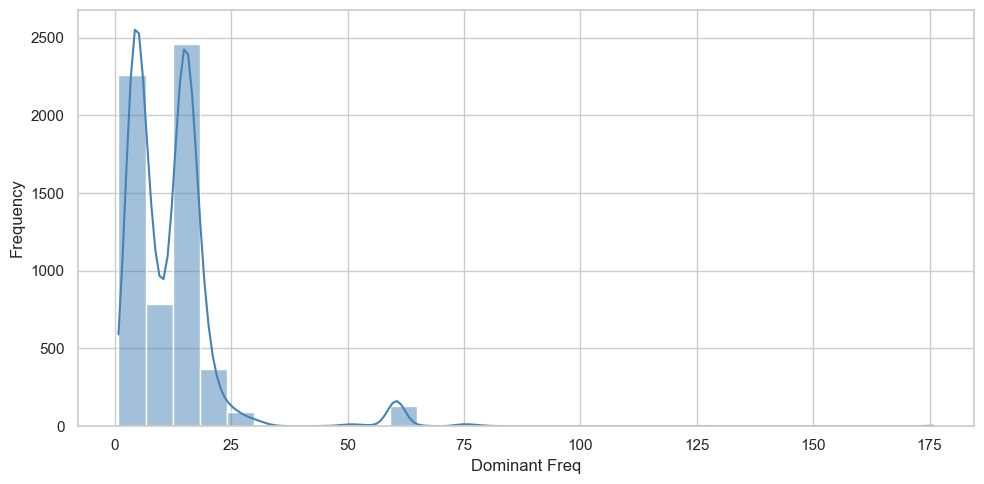

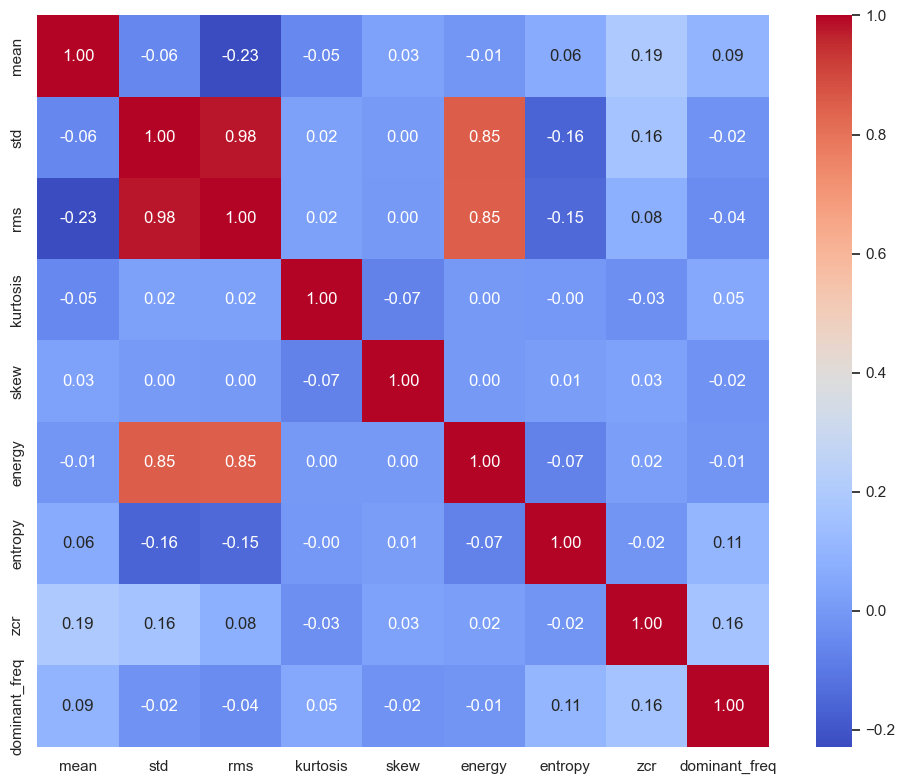

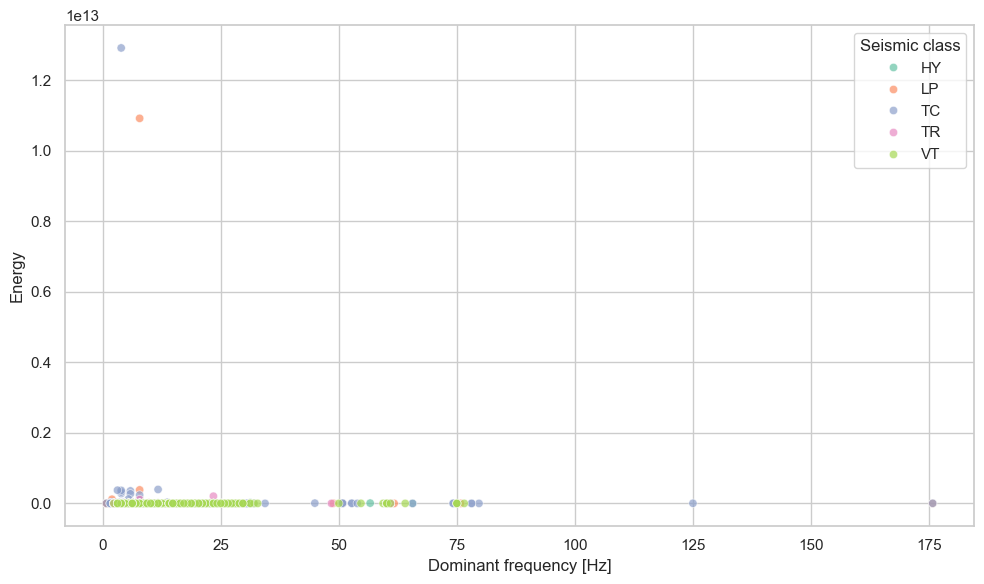

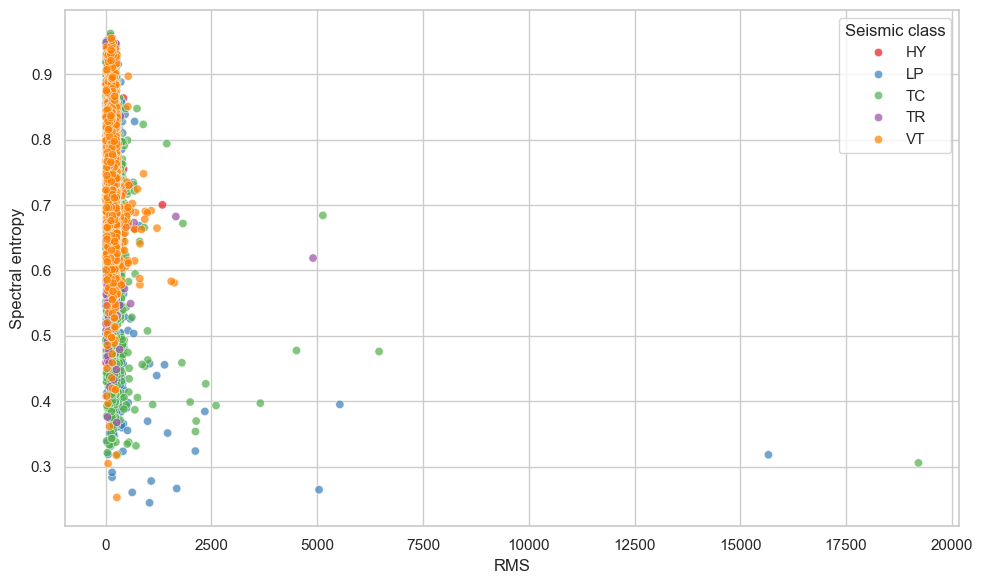

In [25]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Set plot style
sns.set(style="whitegrid")
plt.rcParams["figure.figsize"] = (12, 6)

# Descriptive statistics (full summary)
print(df.describe(include='all'))

# --- Class distribution (event type counts)
plt.figure(figsize=(8, 4))
sns.countplot(data=df, x='label', order=df['label'].value_counts().index, palette="Set2")
# Plot: Distribution of seismic event classes
plt.xlabel("Seismic class")
plt.ylabel("Count")
plt.show()

# List of numerical features to explore
num_features = ['mean', 'std', 'rms', 'kurtosis', 'skew', 'energy', 'entropy', 'zcr', 'dominant_freq']

# --- Violin plots per feature to assess value distribution and outliers by class
for feature in num_features:
    plt.figure(figsize=(10, 6))
    # Plot: Distribution of [feature] by seismic class (violin)
    sns.violinplot(data=df, x='label', y=feature, palette="Set3", inner="box")
    plt.xlabel("Seismic class")
    plt.ylabel(feature.replace("_", " ").title())
    plt.tight_layout()
    plt.show()

# --- Histograms with KDE for each feature (overall distribution)
for feature in num_features:
    plt.figure(figsize=(10, 5))
    # Plot: Histogram of [feature] across all classes
    sns.histplot(df[feature], kde=True, bins=30, color='steelblue')
    plt.xlabel(feature.replace("_", " ").title())
    plt.ylabel("Frequency")
    plt.tight_layout()
    plt.show()

# --- Correlation heatmap between features
corr_matrix = df[num_features].corr()

plt.figure(figsize=(10, 8))
# Plot: Correlation matrix of numerical features
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap="coolwarm", square=True)
plt.xlabel("")
plt.ylabel("")
plt.tight_layout()
plt.show()

# --- Scatterplot: Dominant Frequency vs Energy (colored by class)
plt.figure(figsize=(10, 6))
# Plot: Dominant frequency vs energy by class
sns.scatterplot(data=df, x='dominant_freq', y='energy', hue='label', palette='Set2', alpha=0.7)
plt.xlabel("Dominant frequency [Hz]")
plt.ylabel("Energy")
plt.legend(title="Seismic class")
plt.tight_layout()
plt.show()

# --- Scatterplot: RMS vs Spectral Entropy (colored by class)
plt.figure(figsize=(10, 6))
# Plot: RMS vs spectral entropy by class
sns.scatterplot(data=df, x='rms', y='entropy', hue='label', palette='Set1', alpha=0.7)
plt.xlabel("RMS")
plt.ylabel("Spectral entropy")
plt.legend(title="Seismic class")
plt.tight_layout()
plt.show()


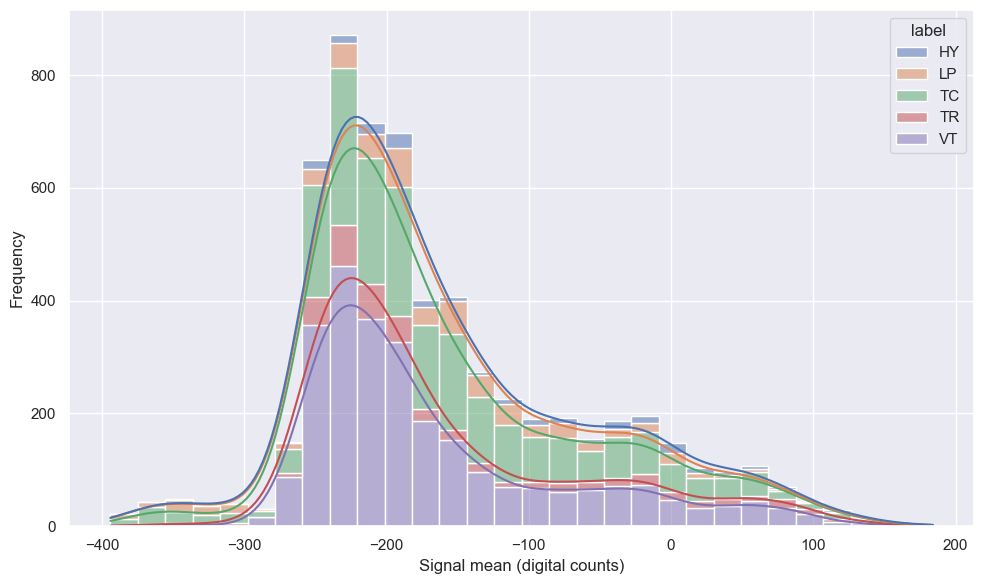

In [38]:
# Histogram of mean by seismic class (separate distributions)
plt.figure(figsize=(10, 6))
# Plot: Histogram of signal mean per class (stacked)
sns.histplot(data=df, x='mean', hue='label', kde=True, bins=30, multiple='stack')
plt.xlabel("Signal mean (digital counts)")
plt.ylabel("Frequency")
plt.tight_layout()
plt.savefig('../reports/figures/hist_mean_stacked.png', dpi=300)
plt.show()

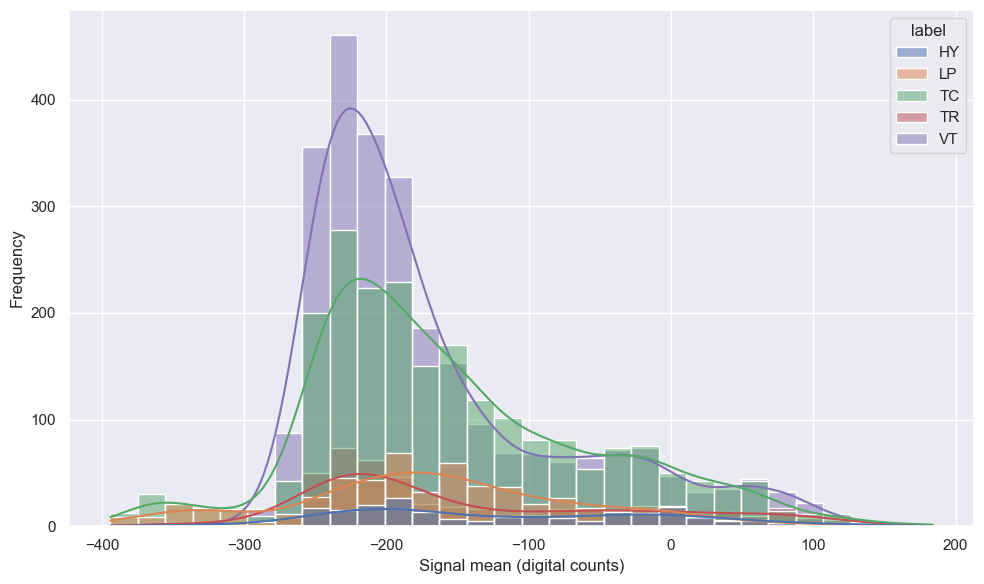

In [39]:
plt.figure(figsize=(10, 6))
# Plot: Histogram of signal mean per class (layered)
sns.histplot(data=df, x='mean', hue='label', kde=True, bins=30, multiple='layer')
plt.xlabel("Signal mean (digital counts)")
plt.ylabel("Frequency")
plt.tight_layout()
plt.savefig('../reports/figures/hist_mean_layered.png', dpi=300)
plt.show()


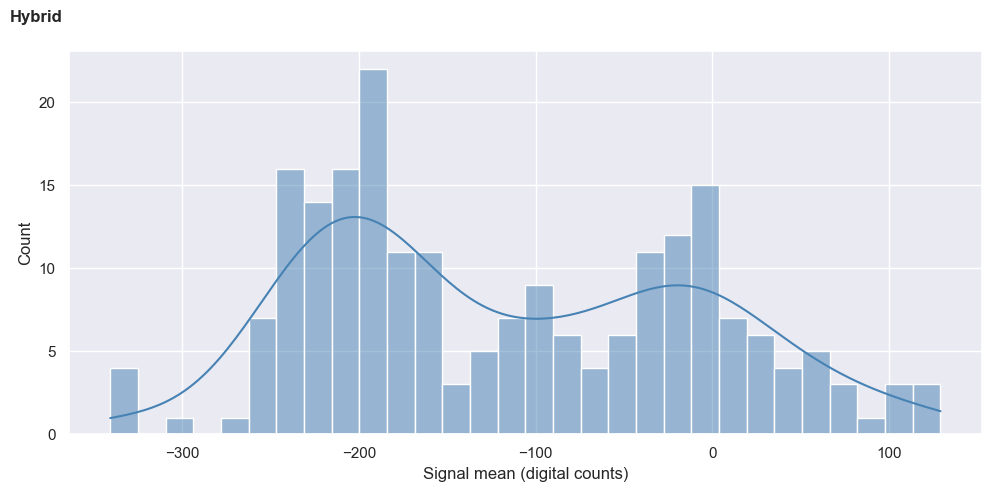

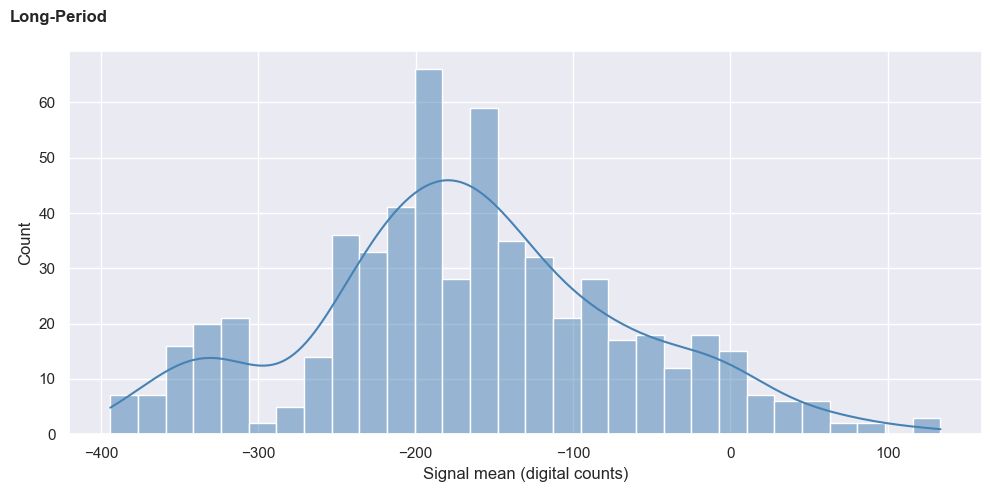

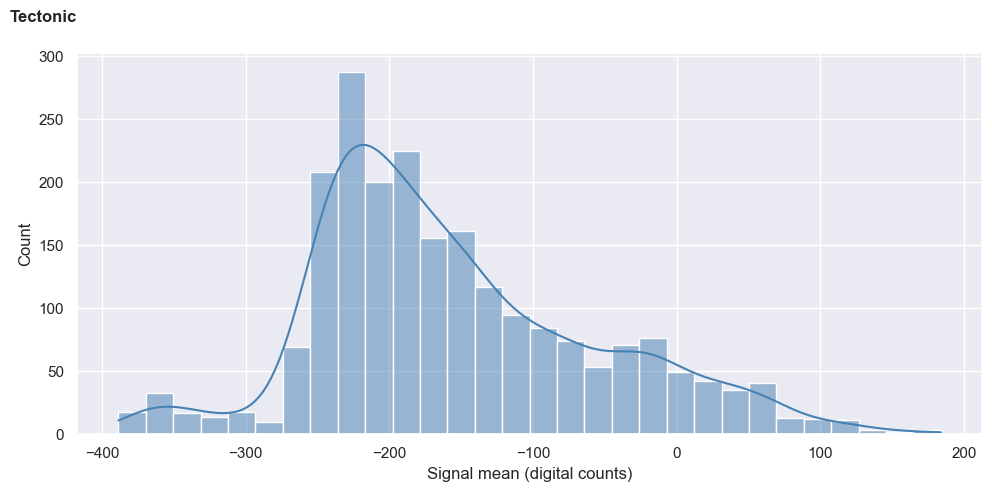

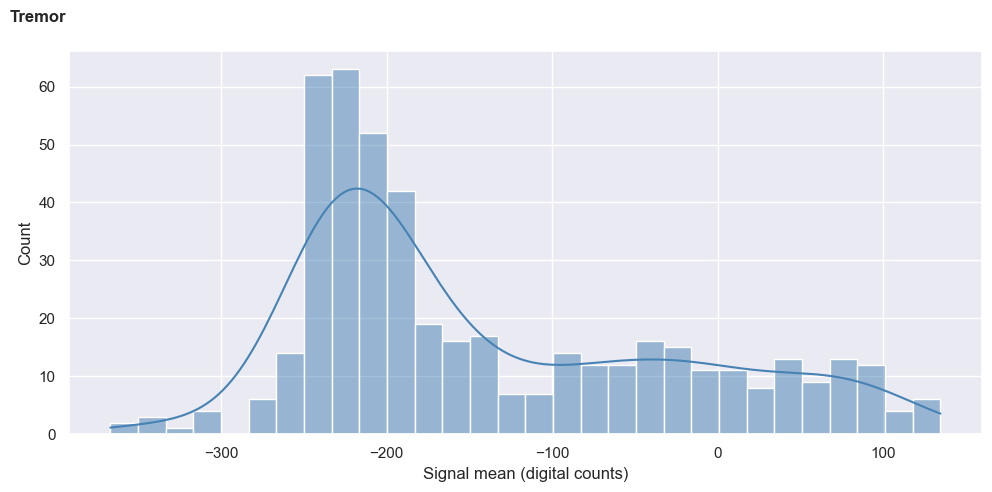

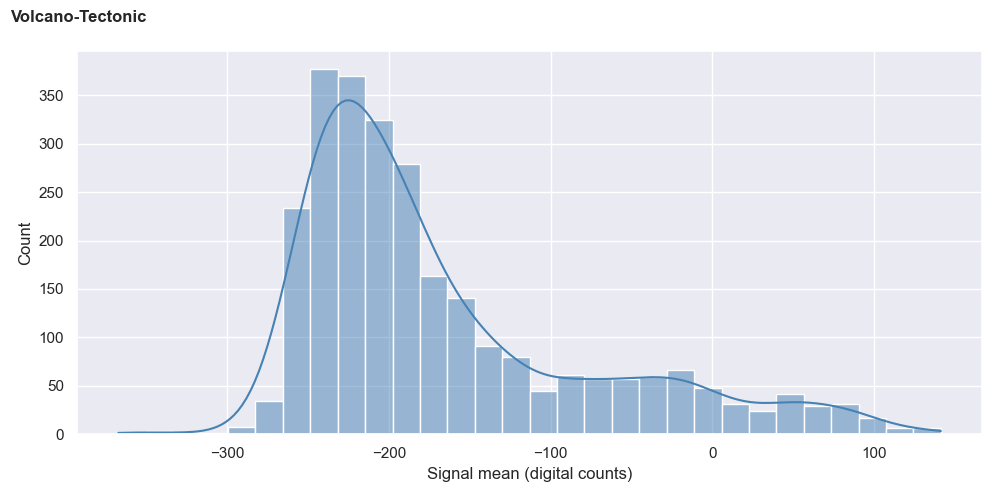

In [40]:
import matplotlib.pyplot as plt
import seaborn as sns
import os

sns.set(style="darkgrid")

# Dictionary for full class names
label_names = {
    "VT": "Volcano-Tectonic",
    "TR": "Tremor",
    "TC": "Tectonic",
    "LP": "Long-Period",
    "HY": "Hybrid"
}

# Make sure output folder exists
output_dir = '../reports/figures'
os.makedirs(output_dir, exist_ok=True)

# Loop for each class
for label in df["label"].unique():
    subset = df[df["label"] == label]

    plt.figure(figsize=(10, 5))
    # Plot: Histogram of signal mean for each seismic class
    sns.histplot(data=subset, x="mean", kde=True, bins=30, color='steelblue')
    plt.xlabel("Signal mean (digital counts)")
    plt.ylabel("Count")
    plt.suptitle(f"{label_names.get(label, label)}", x=0.01, y=0.98, ha='left', fontsize=12, fontweight='bold')
    plt.tight_layout()

    # Save figure with class name in filename
    filename = f"hist_mean_{label}.png"
    plt.savefig(os.path.join(output_dir, filename), dpi=300)
    plt.show()


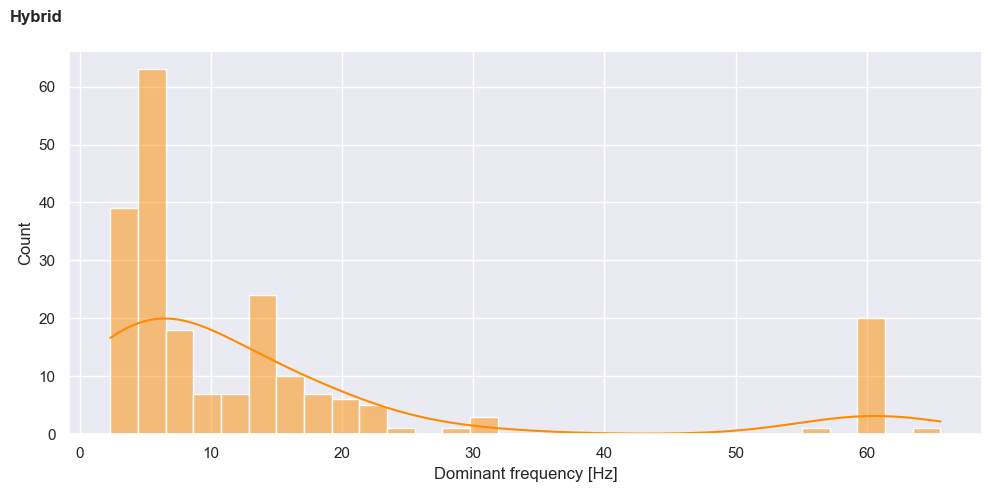

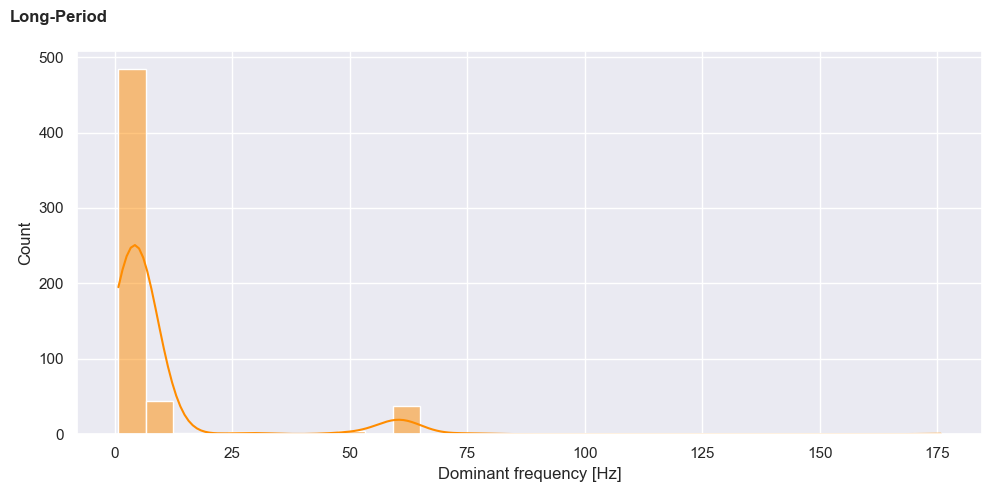

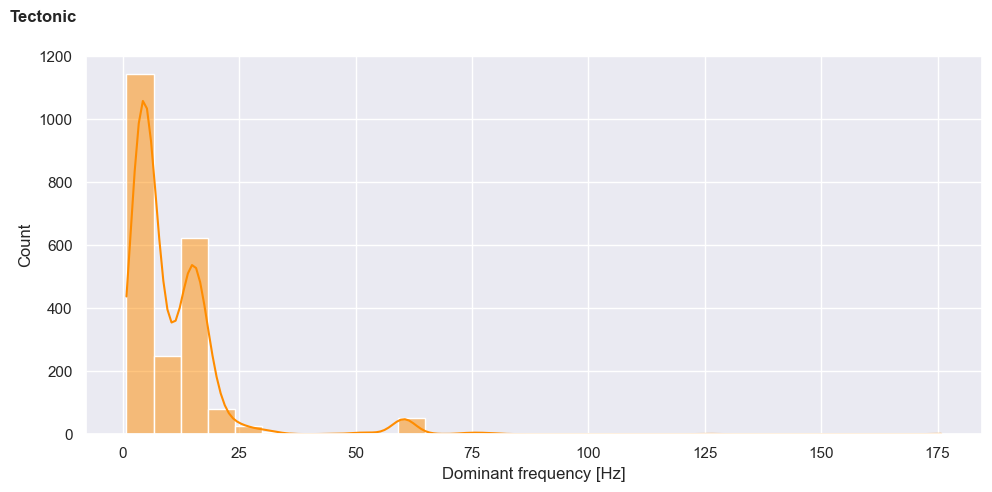

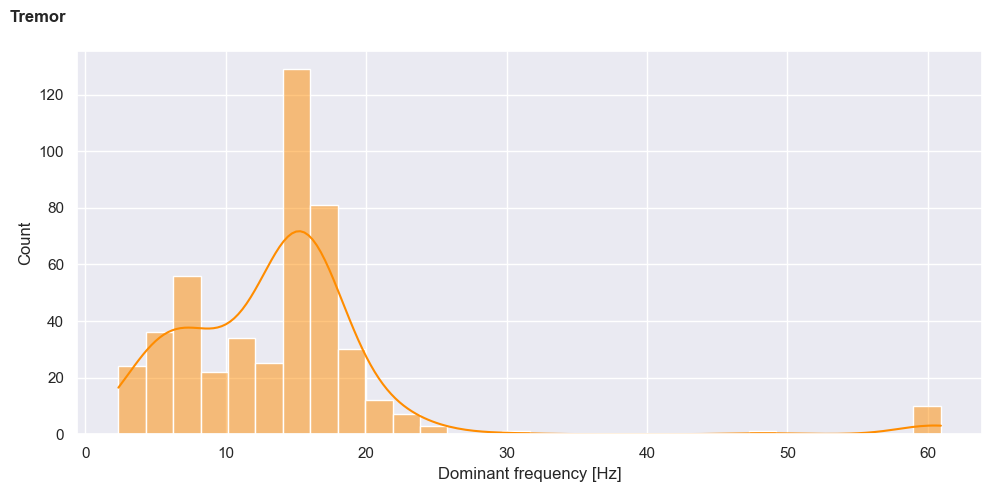

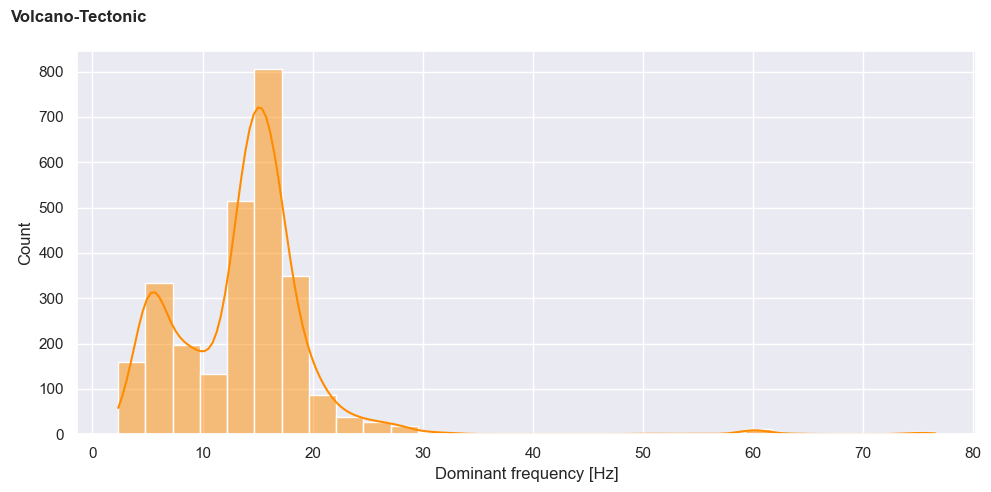

In [41]:
import matplotlib.pyplot as plt
import seaborn as sns
import os

sns.set(style="darkgrid")

# Nombres largos para las clases
label_names = {
    "VT": "Volcano-Tectonic",
    "TR": "Tremor",
    "TC": "Tectonic",
    "LP": "Long-Period",
    "HY": "Hybrid"
}

# Crear carpeta si no existe
output_dir = '../reports/figures'
os.makedirs(output_dir, exist_ok=True)

# Loop por clase sísmica
for label in df["label"].unique():
    subset = df[df["label"] == label]

    plt.figure(figsize=(10, 5))
    # Plot: Histogram of dominant frequency for each seismic class
    sns.histplot(data=subset, x="dominant_freq", kde=True, bins=30, color='darkorange')
    plt.xlabel("Dominant frequency [Hz]")
    plt.ylabel("Count")
    plt.suptitle(f"{label_names.get(label, label)}", x=0.01, y=0.98, ha='left', fontsize=12, fontweight='bold')
    plt.tight_layout()

    # Guardar figura
    filename = f"hist_dominant_freq_{label}.png"
    filepath = os.path.join(output_dir, filename)
    plt.savefig(filepath, dpi=300)

    plt.show()


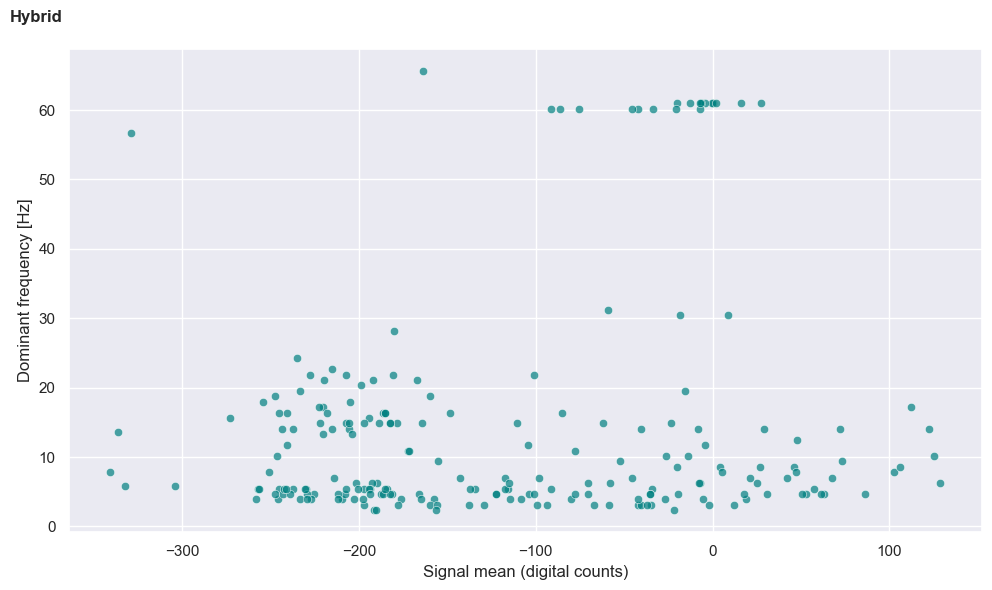

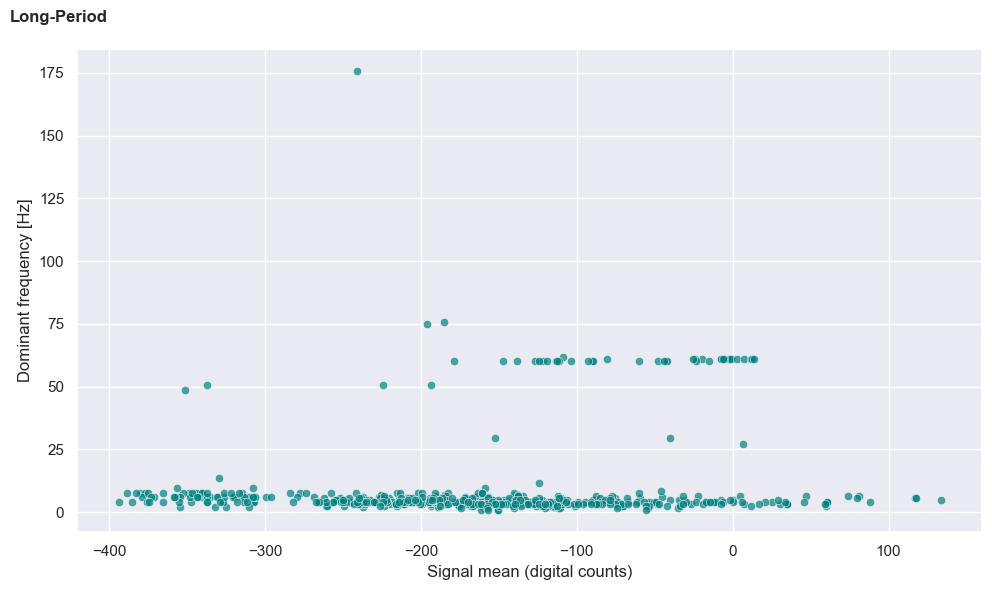

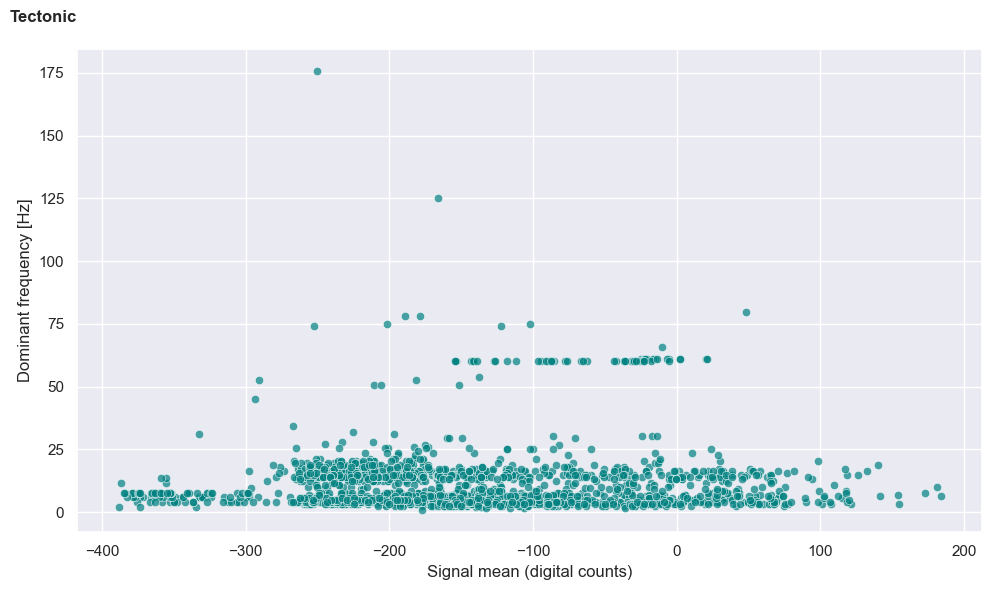

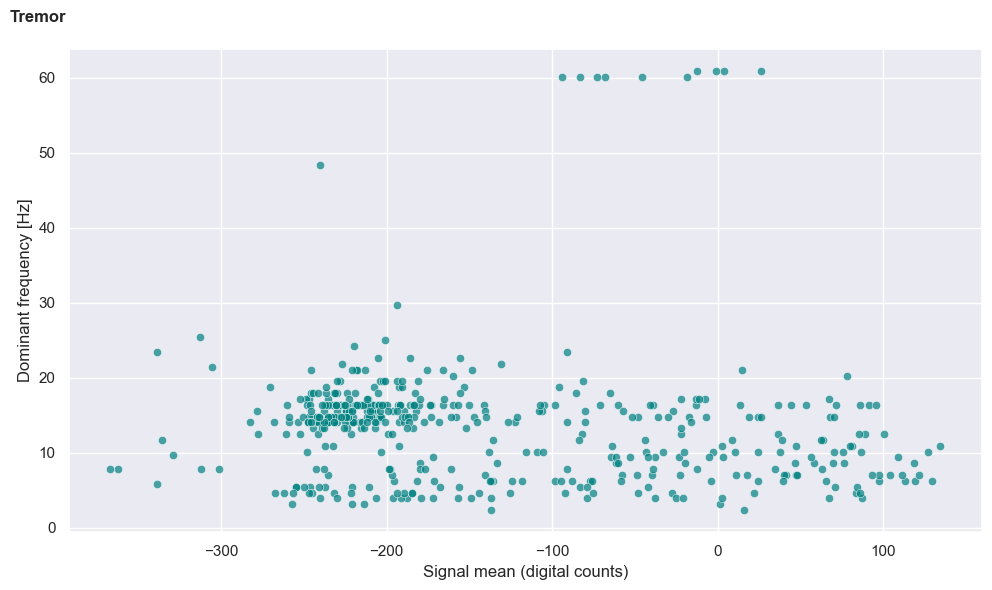

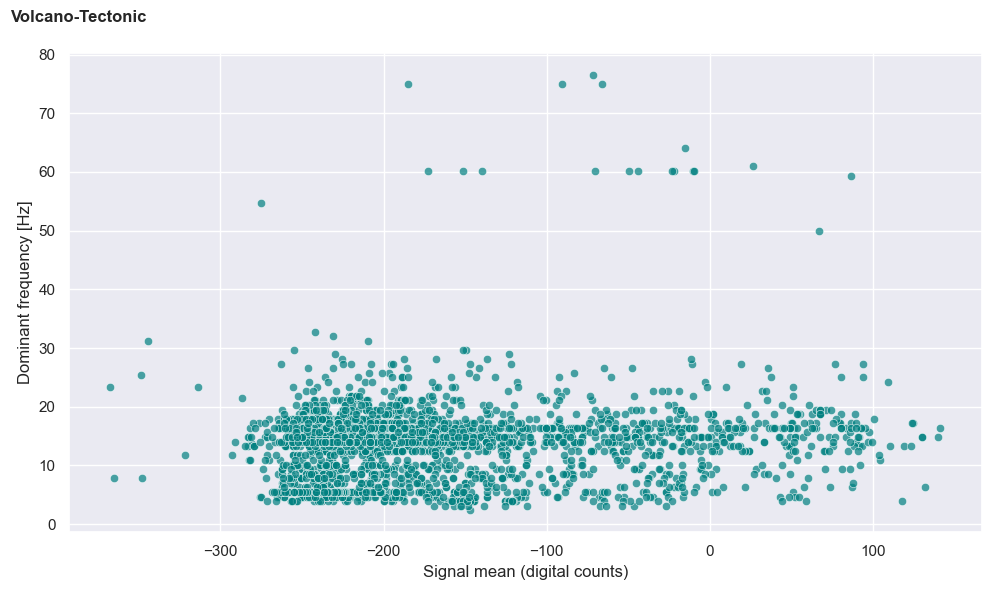

In [42]:
label_names = {
    "VT": "Volcano-Tectonic",
    "TR": "Tremor",
    "TC": "Tectonic",
    "LP": "Long-Period",
    "HY": "Hybrid"
}

for label in df["label"].unique():
    subset = df[df["label"] == label]

    plt.figure(figsize=(10, 6))
    # Plot: Mean vs dominant frequency for one seismic class
    sns.scatterplot(data=subset, x='mean', y='dominant_freq', color='teal', alpha=0.7)
    plt.xlabel("Signal mean (digital counts)")
    plt.ylabel("Dominant frequency [Hz]")
    plt.suptitle(f"{label_names.get(label, label)}", x=0.01, y=0.98, ha='left', fontsize=12, fontweight='bold')
    plt.tight_layout()

    filename = f"scatter_mean_vs_dominant_freq_{label}.png"
    plt.savefig(os.path.join(output_dir, filename), dpi=300)
    plt.show()
